In [1]:
!git clone https://github.com/TheMrGhostman/Semi-supervised-Learning-with-VAE.git

Cloning into 'Semi-supervised-Learning-with-VAE'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 568 (delta 85), reused 208 (delta 63), pack-reused 332
Receiving objects: 100% (568/568), 223.75 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Checking out files: 100% (374/374), done.


In [0]:
import os 
os.chdir("Semi-supervised-Learning-with-VAE/")

In [0]:
import numpy as np
import pandas as pd
import os 
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI, plot_loss
import utils.models as m
import utils.datasets as d
from utils.layers import *

# Load and Prepare Data

In [0]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [4]:
X.shape

(83680, 160)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666, shuffle=True)

In [6]:
X_train.shape

(66944, 160)

In [7]:
y_train.shape

(66944,)

In [0]:
def RNNPreporces_batch(X, y, batch_size):
    length = (X.shape[0]//batch_size)*batch_size
    return X[:length, :], y[:length]

In [0]:
X_train, y_train = RNNPreporces_batch(X_train, y_train, batch_size=300)
X_test, y_test = RNNPreporces_batch(X_test, y_test, batch_size=300)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66900, 160)
(66900,)
(16500, 160)
(16500,)


In [0]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=300, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=300, shuffle=True)

# Model setup

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class DeepGRU_VAE(nn.Module):
	def __init__(self, sequence_len, n_features, latent_dim, hidden_size=128, num_layers=2, batch_size=100, use_cuda=True):
		# ověřit predikci pro jiný batch size !!!!!!!!!!!!!!!!
		super(DeepGRU_VAE, self).__init__()

		self.sequence_len = sequence_len
		self.n_features = n_features
		self.batch_size = batch_size
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.use_cuda = use_cuda

		if self.use_cuda and torch.cuda.is_available():
			self.dtype = torch.cuda.FloatTensor
		else:
			self.dtype = torch.float32

		self.encoder_reshape = Reshape(out_shape=(self.sequence_len, self.n_features))
		self.encoder_gru = nn.GRU(
									input_size=n_features,
									hidden_size=hidden_size,
									num_layers=num_layers,
									batch_first=False,
									bidirectional=False
									) 
		self.encoder_output = VariationalLayer(
									in_features=hidden_size, 
									out_features=latent_dim, 
									return_KL=False
									)

		self.decoder_hidden = nn.Linear(
									in_features=latent_dim,
									out_features=hidden_size,
									bias=True	
									)
		self.decoder_gru= nn.GRU(
									input_size=1,
									hidden_size=hidden_size,
									num_layers=num_layers,
									batch_first=False,
									bidirectional=False
									) 
		self.decoder_output = RecurrentDecoderOutput(
									in_features=hidden_size,
									sequence_len=sequence_len,
									out_features=n_features,
									bias=True
									)
		self.decoder_input = torch.zeros(
									(self.sequence_len, 
									self.batch_size, 
									self.n_features), 
									requires_grad=True
									).type(self.dtype)
		
	def encoder(self, x_in):
		x = self.encoder_reshape(x_in)
		#set_trace()
		x = x.permute(1, 0, 2)
		_, h_end= self.encoder_gru(x)
		h_end = h_end[-1, :, :] # shape(batch_size, num_features)
		return self.encoder_output(h_end)

	def decoder(self, z_in):
		h_state = self.decoder_hidden(z_in)
		#set_trace()
		h_0 = torch.stack([h_state for _ in range(self.num_layers)])
		gru_output, _ = self.decoder_gru(self.decoder_input, h_0)
		mu, sigma = self.decoder_output(gru_output)
		return mu, sigma

	def forward(self, x_in):
		z, mu, sigma = self.encoder(x_in)
		return self.decoder(z), mu, sigma

In [0]:
model_name1 = "DeepGRU_VAE_NLL_300ep_hidden-128_lr-{1e-3,1e-4}_bs-300"

In [0]:
#deepmodel.eval()

In [0]:
deepmodel = DeepGRU_VAE(
                        sequence_len=160, 
                        n_features=1,
                        latent_dim=15,
                        hidden_size=128,
                        num_layers=1,
                        batch_size=300,
                        use_cuda=True
                        )

In [21]:
optim = torch.optim.Adam(deepmodel.parameters(), lr=1e-3)

svi = SVI(
        vae_model=deepmodel,
        optimizer=optim,
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[50], gamma=0.1),
        loss_function="GaussianNLL",
        tensorboard=False,
        model_name=model_name1,
        verbose=True
        )

cuda:0


In [22]:
loss_hist = svi(epochs=300, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/300], average_loss:210.2992, validation_loss:208.2272
Epoch [2/300], average_loss:181.4445, validation_loss:114.5641
Epoch [3/300], average_loss:99.8474, validation_loss:78.5354
Epoch [4/300], average_loss:71.1765, validation_loss:58.2549
Epoch [5/300], average_loss:90.7842, validation_loss:78.4538
Epoch [6/300], average_loss:75.2655, validation_loss:69.1835
Epoch [7/300], average_loss:59.4201, validation_loss:48.9860
Epoch [8/300], average_loss:43.7703, validation_loss:43.4628
Epoch [9/300], average_loss:23.0545, validation_loss:22.4290
Epoch [10/300], average_loss:14.6069, validation_loss:23.1798
Epoch [11/300], average_loss:-1.5587, validation_loss:-30.9000
Epoch [12/300], average_loss:-12.4650, validation_loss:-40.1859
Epoch [13/300], average_loss:-34.9508, validation_loss:-11.6672
Epoch [14/300], average_loss:-33.7187, validation_loss:-37.8804
Epoch [15/300], average_loss:-28.4202, validation_loss:-24.1365
Epoch [16/300], average_loss:-41.3066, validation_loss:-68.0547
Ep

In [26]:
loss_hist = svi(epochs=range(300,400), train_loader=train_loader, validation_loader=test_loader)

Epoch [301/400], average_loss:-172.9483, validation_loss:-172.4562
Epoch [302/400], average_loss:-174.6118, validation_loss:-172.0244
Epoch [303/400], average_loss:-173.6874, validation_loss:-171.0028
Epoch [304/400], average_loss:-173.6801, validation_loss:-173.0610
Epoch [305/400], average_loss:-174.4938, validation_loss:-171.5312
Epoch [306/400], average_loss:-174.2525, validation_loss:-172.2499
Epoch [307/400], average_loss:-174.1561, validation_loss:-171.1087
Epoch [308/400], average_loss:-173.2986, validation_loss:-173.4802
Epoch [309/400], average_loss:-174.8637, validation_loss:-172.6603
Epoch [310/400], average_loss:-174.6799, validation_loss:-171.5367
Epoch [311/400], average_loss:-173.6581, validation_loss:-172.8989
Epoch [312/400], average_loss:-174.5271, validation_loss:-172.5244
Epoch [313/400], average_loss:-174.9350, validation_loss:-172.8121
Epoch [314/400], average_loss:-174.8388, validation_loss:-172.9844
Epoch [315/400], average_loss:-169.9099, validation_loss:-173.

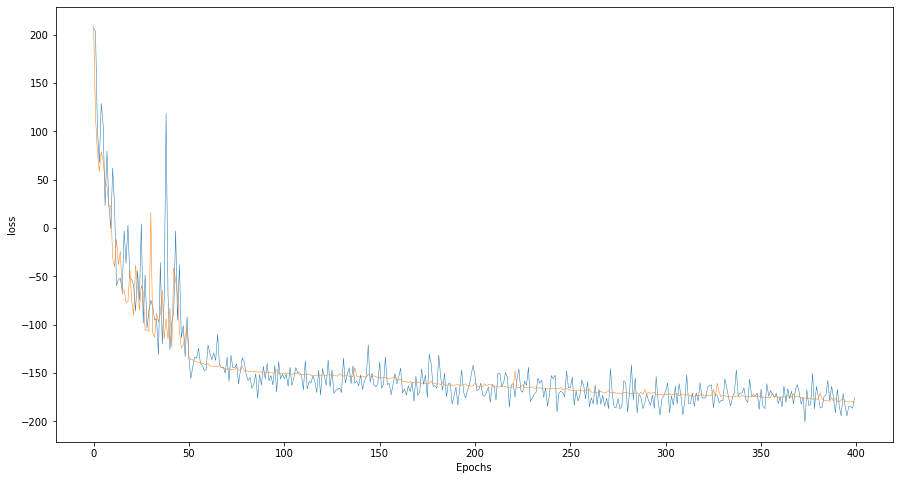

In [29]:
plot_loss(svi, figsize=(15,8), downsample=10)

In [30]:
#torch.save(svi.model, f"models_and_losses/{model_name1}.pt")
#torch.save(svi.optimizer, f"models_and_losses/{model_name1}_optimizer.pt")
#torch.save(svi.model.state_dict(), f"models_and_losses/{model_name1}_state_dict.pt")

torch.save(svi.model, "DeepGRU_VAE_NLL_400ep_hidden-128_lr-{1e-3,1e-4}_bs-300.pt")
torch.save(svi.optimizer, "DeepGRU_VAE_NLL_400ep_hidden-128_lr-{1e-3,1e-4}_bs-300_optimizer.pt")
torch.save(svi.model.state_dict(), "DeepGRU_VAE_NLL_400ep_hidden-128_lr-{1e-3,1e-4}_bs-300_state_dict.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DeepGRU_VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation

cuda:0


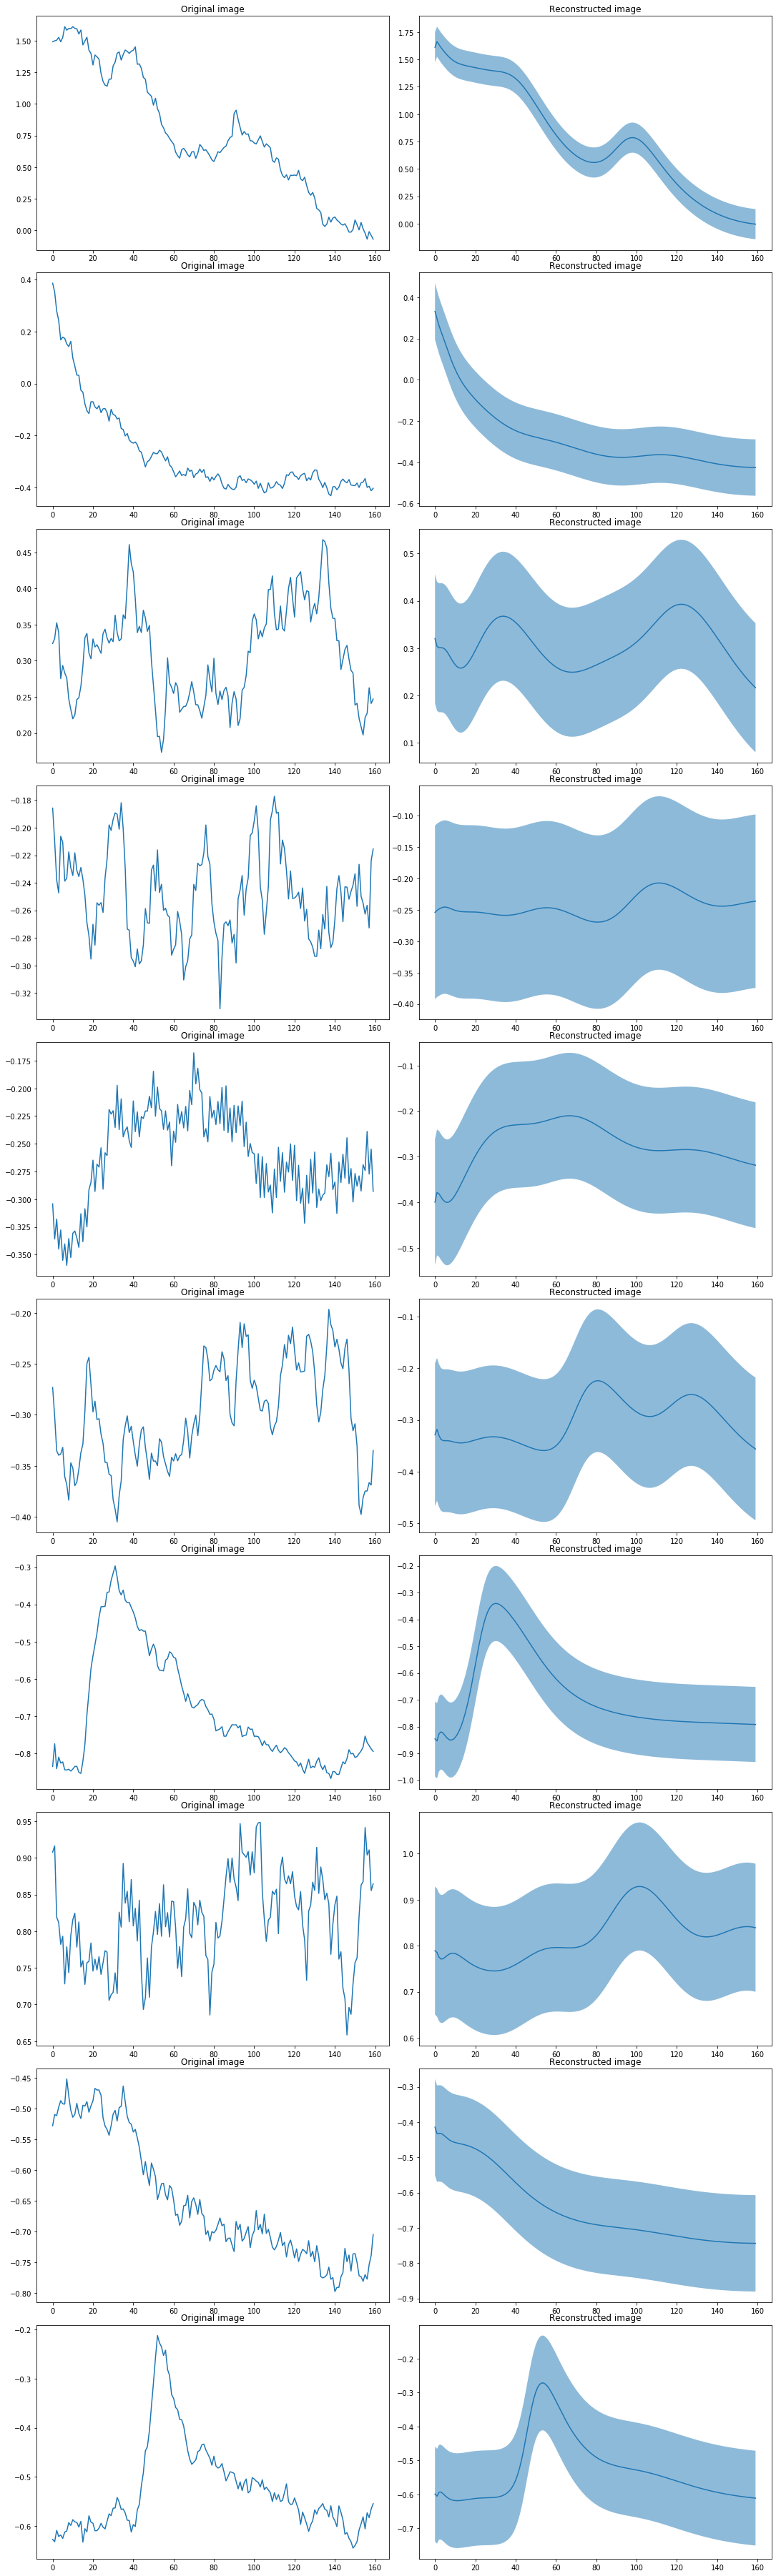

In [31]:
print(device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# Load Model

In [0]:
mod = torch.load(f"models_and_losses/{model_name1}.pt")

In [0]:
mod.eval()

In [0]:
mod = svi.model

In [0]:
z, mu, sigma = mod.encoder(X.to(device))

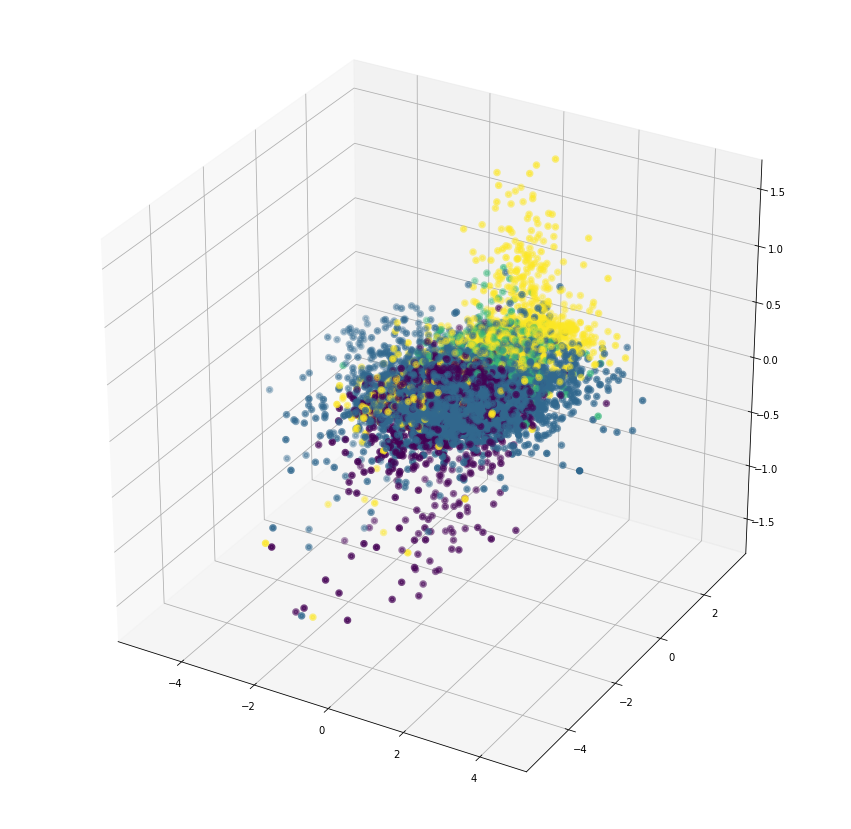

In [34]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod.encoder(X_1.to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

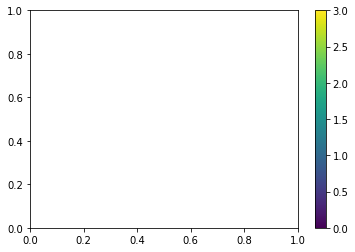

In [35]:
# když přidám colorbar k obrázku tak se nehezky deformuje, tak je tady zvlášť
plt.colorbar(sc, shrink=1)

In [0]:
#np.save("data/lstm-mu-test.npy", mu)
#np.save("data/lstm-y-test",cl)